# Chapter 18: Double Deep Q Learning

Deep Q learning has a well-known problem of overestimating Q values. In most cases, this is not an issue since we only care about the relative magnitude of the Q-values for different actions. However, in complicated situations such as Atari games, this poses a problem and leads to wrong actions in certain scenarios. 

To overcome this, we need to use double Q learning: we'll use one deep Q network for training and another deep Q network for predicting, and periodically updated the target Q network with the weights from the training Q network. 

The double deep Q learning can play Atari Games very efficiently. You’ll learn to create a deep neural network with convolutional layers to extra features from the Atari gameplay screenshots. You’ll use the Atari Breakout game as an example in this chapter. It can eliminate almost all bricks on the screen. 

More important, the agent sends the ball to the back of the wall multiple times once there is at least one opening to the back of the wall. The agent has definitely "learned" that it's more efficient to earn points that way than directly aiming at the bricks.

Furthermore, the model is highly scalable, and you can tweak the model slightly and apply to other Atari games such as SpaceInvaders, Seaquest, Pong, and BeamRiders, as you’ll see in the next few chapters. 

The model used in this chapter is largely based on the example script by Jacob Chapman and Mathias Lechner https://keras.io/examples/rl/deep_q_network_breakout/. I made some minor changes to shorten the script, such as using the *deque()* method from the ***collections*** library so that we don't have to keep track of the size of the memory buffer or the size of the running rewards. 

In the left frame of the animation below, you can see that the agent has sent the ball to the back of the wall five consecutive times. It's clear that the agent has "learned" to do this on purpose because this is a more efficient way of earning rewards than aiming at the bricks directly: 
<img src="https://gattonweb.uky.edu/faculty/lium/ml/breakout_highlights.gif" />

***
$\mathbf{\text{Create a subfolder for files in Chapter 18}}$<br>
***
We'll put all files in Chapter 18 in a subfolder /files/ch18. The code in the cell below will create the subfolder.

***

In [1]:
import os

os.makedirs("files/ch18", exist_ok=True)

***
$\mathbf{\text{Install OpenAI Baselines for Chapter 18}}$<br>
***
We'll use OpenAI Baselines to train several Atari games from this chapter onwards. The Baselines library provides high quality implementations of reinforcement learning algorithms and it makes our training of complicated Atari games more effective. For more details, go to https://github.com/openai/baselines.

To install OpenAI Baselines, make sure that you have installed atari_py and ROMS on your computer. If not, refer to Chapter 16 on how to install. 

Also, make sure you are using version 0.15.7 of the OpenAI Gym environment. In case you accidentally installed a different version, run the following lines of code to correct it.

`pip uninstall gym`

`pip install gym==0.15.7`
 

Here are the steps to install OpenAI Baselines:
* Step 1: Make sure you have Git installed on your computer; if not, see instructions here https://git-scm.com/book/en/v2/Getting-Started-Installing-Git. 
* Step 2: Open the Anaconda prompt (Windows) or a terminal (MAC or Linux) and activate the virtual environment ***animatedML***. Clone the OpenAI Baselines repository by running the following line of command:

`git clone https://github.com/openai/baselines.git`

* Step 3: Go into the baselines directory by running the following line of command:

`cd baselines`

* Step 4: Install the baselines package in the virtual environment by running the following command:

`pip install -e .`

Make sure you don't miss the dot at the end of the above command. 

After that, restart your Jupyter Notebook for the package to take effect.
***

## 1. Get Started with the OpenAI Baselines

In this section, you'll learn the special features of OpenAI Baselines. I'll focus on the features that are different from the game without using the baselines package. For comparison, we'll use the Breakout game since you have already used it in Chapter 17.

### 1.1. The Breakout Game with OpenAI Baselines

Remember in Chapter 17 we need to reconfigurate the rewards by counting the number of lives remaining for the agent? Well, with the baselines game wrapper, the agent has one life in each episode. That is, each time the agent loses a life (i.e., the paddle misses the ball), the episode ends. In the original Atari Breakout game, the agent starts with 5 lives and the episode ends when the agent loses all 5 lives. 

This makes reconfiguring the reward system much easier. Each time the game ends (i.e., done==True), we set the Q-value to -1. This is crucial for the success of the training. 

Let's make sure that's indeed the case. Run the code in the cell below.

In [3]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind

# Use the Baseline Atari environment
env = make_atari("BreakoutNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)

obs = env.reset()
while True:
    # randomly pick actions
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    print(action, reward, done, info)
    # Render the env
    env.render()
    if done:
        break

2 0.0 False {'ale.lives': 5}
2 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
0 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
2 0.0 False {'ale.lives': 5}
0 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
0 0.0 False {'ale.lives': 5}
0 0.0 False {'ale.lives': 5}
1 0.0 False {'ale.lives': 5}
2 0.0 False {'ale.lives': 5}
3 0.0 False {'ale.lives': 5}
2 0.0 False {'ale.lives': 5}
2 0.0 True {'ale.lives': 4}


As you can see, the agent starts with 5 lives. Once the agent loses one life, the variable done becomes True and the episode ends. Note that the reward is still 0, but we can code it as -1 by using this line of code; you'll see it in the script for training later:

```python
    # Each time the agent loses a life, set Q to -1; important
    new_Qs = Qs * (1 - dones) - dones
```

Run the following to close the game window.

In [5]:
env.close()

### 1.2. Preprocessed Frames from the OpenAI Baselines

Remember in Chapters 16 and 17 we need to preprocess raw images from the Pong and Breakout games by cropping, downsizing, and differencing the images? Well, the baselines game wrapper does all those for you. In each time step, it returns four consecutive frames of preprocessed images, each with a size of 84 by 84.  

Let's visualize the preprocessed images from the baseline package. Run the code in the cell below.

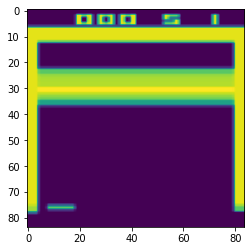

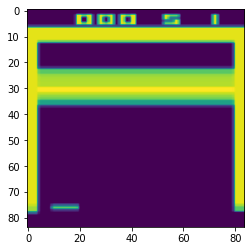

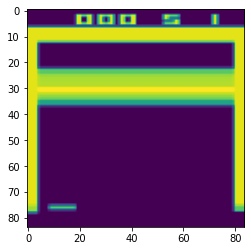

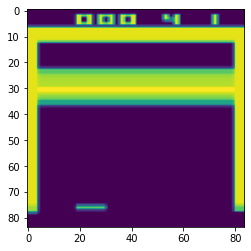

In [6]:
import matplotlib.pyplot as plt
import numpy as np

npobs=np.array(obs)
for i in range(4):
    plt.imshow(npobs[:,:,i])
    plt.show()

You can see the four consecutive frames, and the paddle has moved to the right at the bottom of the frames. 

## 2. Train the Agent with A Double Deep Q Network
We'll train the agent to play the Atari Breakout game with a double deep Q network in this section.

### 2.1. Create A Double Deep Q Network
Deep Q learning has a well-known problem of overestimating the Q values. To overcome this, we use double Q learning: we'll use one deep Q network for training and another deep Q network for predicting, and periodically updated the target network from the training network. 

The deep Q network we use has convolutional layers since the inputs are two-dimensional pictures. We can use convolutional layers to extract features from the graphs and associate them with game strategies. 

### 2.2. Train the Agent
The script below trains the agent to play the Breakout game. It is largely based on the example script by Jacob Chapman and Mathias Lechner https://keras.io/examples/rl/deep_q_network_breakout/. I made some minor changes to shorten the script, such as using the *deque()* method from the ***collections*** library so that we don't have to keep track of the size of the memory buffer or the size of the running rewards. 

In [ ]:
import random
from collections import deque
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from baselines.common.atari_wrappers import make_atari
from baselines.common.atari_wrappers import wrap_deepmind

# Use the Baseline Atari environment
env = make_atari("BeamRiderNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)

# Discount factor for past rewards
gamma = 0.99 
# batch size
batch_size = 32  

# The number of actions in breakout is 4
num_actions = 4

# The same double Q deep neural network, applies to all Atari games
def create_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))
    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)
    return tf.keras.Model(inputs=inputs, outputs=action)

# Double Deep Q Learning here
# The model predicts Q-values, to determine action 
dnn=create_model()
# Target model predicts future rewards
# The weights of a target model are updated every 10000 frames thus when the
# loss between the Q-values is calculated the target Q-value is stable.
target_dnn=create_model()

# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
loss_function = tf.keras.losses.Huber()

# See how many trainable parameters in the deep neural network
print(dnn.summary())

# Create a replay buffer with a maximum length of 50000
# If you don't have enough memory on your computer, change it to 20000
memory=deque(maxlen=50000)
# Create a running rewards list with a length of 100
running_rewards=deque(maxlen=100)

# Replay and update model parameters
def replay():
    # select a batch from the buffer memory
    samples = random.sample(memory,batch_size)
    dones = []
    frames = []
    new_frames = []
    rewards = []
    actions = []
    for sample in samples:
        frame, new_frame, action, reward, done = sample
        frames.append(frame)
        new_frames.append(new_frame)
        actions.append(action)
        dones.append(done)
        rewards.append(reward)
    frames=np.array(frames)
    new_frames=np.array(new_frames)
    dones=tf.convert_to_tensor(dones)

    # update the Q table
    preds = target_dnn.predict(new_frames, verbose=0)
    Qs = rewards + gamma * tf.reduce_max(preds, axis=1)
    # Each time the agent loses a life, set Q to -1; important
    new_Qs = Qs * (1 - dones) - dones

    # update model parameters
    onehot = tf.one_hot(actions, num_actions)
    with tf.GradientTape() as t:
        Q_preds = dnn(frames)
        # Calculate old Qs for the action taken
        old_Qs = tf.reduce_sum(tf.multiply(Q_preds, onehot),axis=1)
        # Calculate loss between new Qs and old Qs
        loss = loss_function(new_Qs, old_Qs)
    # Update using backpropagation
    gs = t.gradient(loss,dnn.trainable_variables)
    optimizer.apply_gradients(zip(gs,dnn.trainable_variables))
    
# Let the game begin
running_reward = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000

for episode in range(1, 100000): 
    # reset state and episode reward before each episode
    state = np.array(env.reset())
    episode_reward = 0
    
    # Allow 10,000 steps per episode
    for timestep in range(1, 10001):
        frame_count += 1
        # Calculate current epsilon based on frame count
        epsilon = max(0.1, 1 - frame_count * (1-0.1) /1000000)
        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        # Use exploitation
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = dnn(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)
        episode_reward += reward
        # Change done from True/False to 1.0 or 0.0 to prevent error
        if done==True:
            done=1.0
        else:
            done=0.0
        # Save actions and states in replay buffer
        memory.append([state, state_next, action, reward, done])
        # current state becomes the next state in next round
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(memory) > batch_size:
            replay()

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            target_dnn.set_weights(dnn.get_weights())
            running_reward = np.mean(np.array(running_rewards))
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode, frame_count))
            # Periodically save the model
            dnn.save("files/ch18/DoubleQ_Breakout.h5")
        if done==1.0:
            running_rewards.append(episode_reward)
            break
    # Condition to consider the task solved
    if running_reward > 40:  
        print(f"Solved at episode {episode}!")
        # save the final model
        dnn.save("files/ch18/DoubleQ_Breakout_final.h5")        
        break

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 32)        8224      
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1606144   
                                                                 
 dense_5 (Dense)             (None, 4)                 2052

The number of trainable parameters is 1,686,180. The model takes several days to train. But you can use a trained model saved as files/ch18/breakout.h5. 

## 3. Test the Trained Model
Next, you'll first play five episodes of the game using the pre-trained model, so that you can visualize the pre-trained model in action. 

After that, you'll play the game 100 episodes and see what is the average score, without the graphical rendering of the game frames. 

### 3.1. Testing One Original Episode
The original Atari Breakout game has 5 lives. But the baseline package breaks it down to five smaller episodes. 

Here you'll play the game five consecutive episodes with the baseline package so that you'll have one full original episode. 

You'll turn on the graphical rendering of the game frames so that you can visualize the game in action.

In [5]:
import numpy as np
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import tensorflow as tf

reload = tf.keras.models.load_model("files/ch18/breakout.h5")

# Use the Baseline Atari environment
env = make_atari("BreakoutNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)

for i in range(5):
    state = env.reset()
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(4)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        env.render()
        state=obs
        if done:
            break

env.close()

The trained model is able to remove most, if not all bricks in the game. 

More important, the agent sends the ball to the back of the wall multiple times once there is at least one opening to the back of the wall. The agent has definitely "learned" that it's more efficient to earn points that way than directly aiming at the bricks. 

### 3.2. Play Multiple Games and Test the Average Score

We now play 100 games and turn off the graphical rendering. We'll see what is the average score.  

In [ ]:
import numpy as np
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import tensorflow as tf

reload = tf.keras.models.load_model("files/ch18/breakout.h5")

# Use the Baseline Atari environment
env = make_atari("BreakoutNoFrameskip-v4")
# Process and stack the frames
env = wrap_deepmind(env, frame_stack=True, scale=True)
scores = []
for i in range(100):
    state = env.reset()
    score = 0
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(4)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        #env.render()
        state=obs
        score += reward
        if done:
            print(f"the score in episode {i+1} is {score}")
            scores.append(score)
            break
env.close()

print(f"the average score is {np.array(scores).mean()}")

The average score is about 20 per episode.

## 4. Animate Successful Episodes
We'll highlight episode where the agent purposefully sends the ball to the back of the wall multiple times. 

### 4.1. Collect Successful Episodes
We'll first record 25 episodes, and this is equivalent to five full original Atari Breakout game. 

The script below accomplishes that.

In [8]:
import imageio

frames = []
for i in range(25):
    state = env.reset()
    episode_frames = []
    for j in range(10000):
        if np.random.rand(1)[0]<0.01:
            action = np.random.choice(4)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = reload(state_tensor, training=False)
            # Take the best action
            action = tf.argmax(action_probs[0]).numpy()    
        obs, reward, done, info = env.step(action)
        #env.render()
        state=obs
        episode_frames.append(env.render(mode='rgb_array'))
        if done:
            frames.append(episode_frames)
            imageio.mimsave(f"files/ch18/breakout_episode{i+1}.gif", episode_frames, fps=240)
            break
env.close()

import pickle 
pickle.dump(frames, open(f'files/ch18/breakout_frames.p', 'wb'))

You'll see 25 short animations in your local folder. If you view them as extra large icons, you can easily tell in which ones the agent sends the ball to the back of the wall multiple times. The bricks remaining are visible from the thumbnail pictures of the animations.  

### 4.2. Zoom in on Certain Steps
Next, we'll zoom in on the steps of the game when the agent sends the ball to the back of the wall multiple times. 
For example, I will zoom in episodes 56 and 67 (the episodes for you will likely be different).

Next, you'll break down episode 56 into individual pictures so that you know which frame to start and which one to stop. 

In [ ]:
import os
import matplotlib.pyplot as plt

os.makedirs("files/ch18/photos", exist_ok=True)
for i in range(len(frames[55])):
    plt.imshow(frames[55][i])
    plt.axis("off")
    plt.savefig(f"files/ch18/photos/photo{i+1}")

By browsing through the pictures, it seems that the agent has sent the ball to the back of the wall from photos numbered 100 to 294. We therefore keep only those frames, like so.

In [11]:
imageio.mimsave("files/ch18/breakout_highlight.gif", frames[55][100:294], fps=240)

In the animation below, you can see that the agent has sent the ball to the back of the wall five consecutive times. It's clear that the agent has "learned" to do this on purpose because this is a more efficient way of earning rewards than aiming at the bricks directly. 

In [20]:
%%HTML 
<img src="https://gattonweb.uky.edu/faculty/lium/ml/breakout_highlight.gif" />

Similarly, we can break down episode 67 into individual pictures so that you know which frame to start and which one to stop.

In [ ]:
os.makedirs("files/ch18/photos2", exist_ok=True)
for i in range(len(frames[66])):
    plt.imshow(frames[66][i])
    plt.axis("off")
    plt.savefig(f"files/ch18/photos2/photo{i+1}")

By browsing through the pictures, it seems that the agent has sent the ball to the back of the wall from photos numbered 140 to 289. We therefore keep only those frames, like so.

In [17]:
imageio.mimsave("files/ch18/breakout_highlight2.gif", frames[66][140:289], fps=240)

The animation looks as follows:

In [25]:
%%HTML 
<img src="https://gattonweb.uky.edu/faculty/lium/ml/breakout_highlight2.gif" />

### 4.3. Combine the Highlights
We'll combine the two highlights into one animation.

In [24]:
frames1 = frames[55][100:294]
frames2 = frames[66][140:289]
frames2 = frames2 + frames2
fs = []
for i in range(min(len(frames1), len(frames2))):
    if i%2==0:
        f1 = frames1[i]
        f2 = frames2[i]
        middle = np.full(f1.shape, 255).astype("uint8")
        f12 = np.concatenate([f1, middle, f2], axis=1)
        fs.append(f12)
imageio.mimsave('files/ch18/breakout_highlights.gif', fs, fps=600) 

The animation looks as follows:

In [26]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/breakout_highlights.gif" />

The animation shows that the agent can "learn" to score more efficiently by just interacting with the game environment. This is the essence of reinforcement learning!